In [21]:
import pandas as pd
import os
image_folder = "data\\120 Rocks"
image_names = [os.path.splitext(image)[0] for image in os.listdir(image_folder) if image.endswith(".jpg")]

human_data = pd.read_csv("data\\rocks_120_full_matrix.csv", index_col=0)
human_data.columns = image_names[:len(human_data.columns)]
human_data.index = image_names[:len(human_data.columns)]

In [35]:
import json
with open("number_map.json", "r", encoding="utf-8") as f:
    number_map = json.load(f)

In [37]:
import numpy as np

def get_average_rating(logprobs):
    # We get a weighted average using the logprobs. The logprobs are actually nondeterministic
    # even with a fixed random seed, so different runs might have slightly different results.
    ratings = np.array([i+1 for i in range(9)])
    weights = np.array([0.]*9)
    for lp in logprobs:
        token = token = lp["token"].strip().lower()
        i = number_map.get(token, token) # Convert what we can to numerical digits
        try:
            i = int(i) - 1
            weights[i] += np.exp(lp["logprob"])
        except:
            continue
    try:
        av = np.average(ratings, weights=weights)
    except:
        av = 0.0
    return av


In [38]:
def process_batch_output(file_path):
    results = []
    with open(file_path, "r") as f:
        for line in f:
            data = json.loads(line)
            logprobs = data["response"]["body"]["choices"][0]["logprobs"]["content"][0]['top_logprobs']
            avg_rating = get_average_rating(logprobs)
            rock1, rock2 = data['custom_id'].split(",")
            human = human_data[rock1][rock2]
            results.append({'rock1': rock1, 'rock2': rock2, "Human Rating": human, "ChatGPT Rating": avg_rating})
    return pd.DataFrame(results)


In [39]:
# Example usage
output_file = "c:\\Users\\crasa\\Documents\\GitHub\\ChatGPT-Categorization\\batch_output.jsonl"
results = process_batch_output(output_file)
results

,rock1,rock2,Human Rating,ChatGPT Rating
0,I_Andesite_1_120,I_Andesite_2_120,6.571429,4.008533
1,I_Andesite_1_120,I_Andesite_3_120,5.166666,4.047382
2,I_Andesite_1_120,I_Andesite_4_120,6.583334,3.679198
3,I_Andesite_1_120,I_Basalt_1_120,4.200000,5.986136
4,I_Andesite_1_120,I_Basalt_2_120,2.000000,2.008577
5,I_Andesite_1_120,I_Basalt_3_120,4.800000,3.996133
6,I_Andesite_1_120,I_Basalt_4_120,4.714286,3.003947
7,I_Andesite_1_120,I_Diorite_1_120,2.666667,3.022967
8,I_Andesite_1_120,I_Diorite_2_120,1.500000,2.268941
9,I_Andesite_1_120,I_Diorite_3_120,4.400000,2.029312


In [40]:
results.corr(numeric_only=True)

,Human Rating,ChatGPT Rating
Human Rating,1.000000,0.450842
ChatGPT Rating,0.450842,1.000000


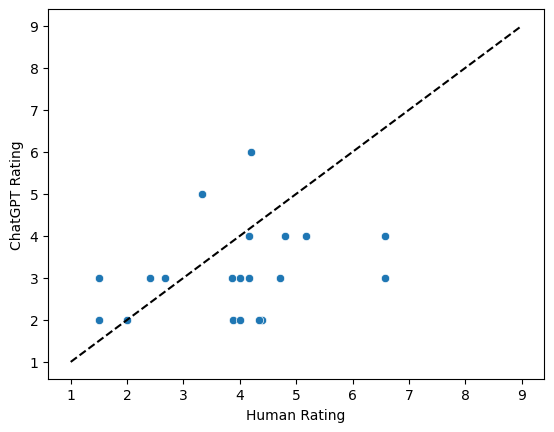

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(results, x="Human Rating", y="ChatGPT Rating")
plt.plot([1, 9], [1, 9], 'k--')